In [284]:
#!conda install -c conda-forge python-docx seaborn


In [285]:
%load_ext autoreload
%aimport model
%autoreload 2
#from model import ModelShaving
# from docplex.mp.advmodel import AdvModel
import numpy as np
import pandas as pd
import pickle
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [286]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display


In [309]:
sns.set_style("whitegrid")
figure_size =[20,6]
save_dir = 'media'

In [288]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
invalid = '<>:"/\|?* '


In [289]:
filename = "ConsommationUniversite.pickle"
df = pd.read_pickle(filename)
print(df.shape)
year = df['year'].unique()
print(year)
print(df.columns)
print(max(df['Power [kW]']),max(df['Power Clipped [kW]']))

(69504, 15)
[2015 2016]
Index(['Timestamp', 'Power [kW]', 'year', 'month', 'day', 'hour', 'dayofyear', 'quarter', 'week', 'weekday', 'is_workday', 'year_month', 'month_week', 'Power Clipped [kW]', 'is_peak'], dtype='object')
12442.0 2442.0


In [290]:
def generate_Si(dataf, start, stop,name):
    d = pd.DataFrame(index=dataf.index)
    for i, (b, e) in enumerate(zip(start,stop)):
        ts = dataf.between_time(b, e)
        n = name+str(i+1)
        #try:
        d.loc[dataf.index,n] = 0

        #except:
        #    pass
        d.loc[ts.index,n] = np.where((ts['is_workday'] ==1), 1, 0)
    return d.copy(True)

In [291]:
df['t'] = df.index

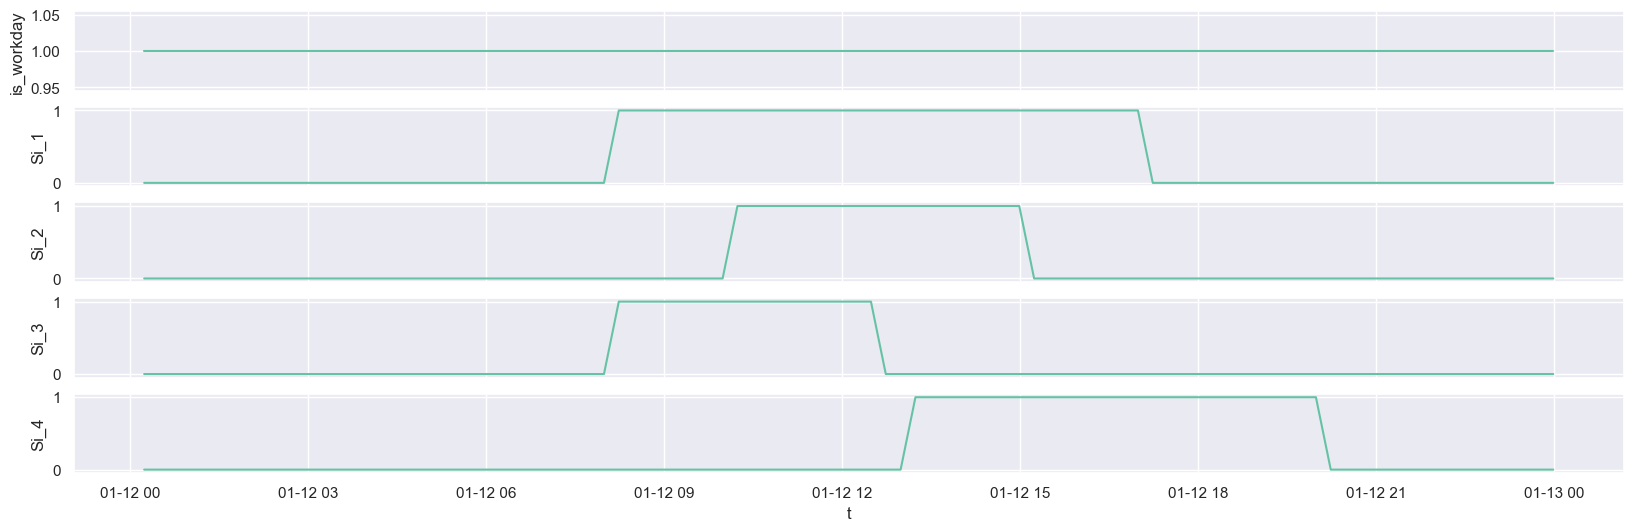

In [292]:
en = df[(df['dayofyear'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')

en = pd.concat([en, sig], axis=1)

title = "Connections lors d'une journée"
what= 't'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])
for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


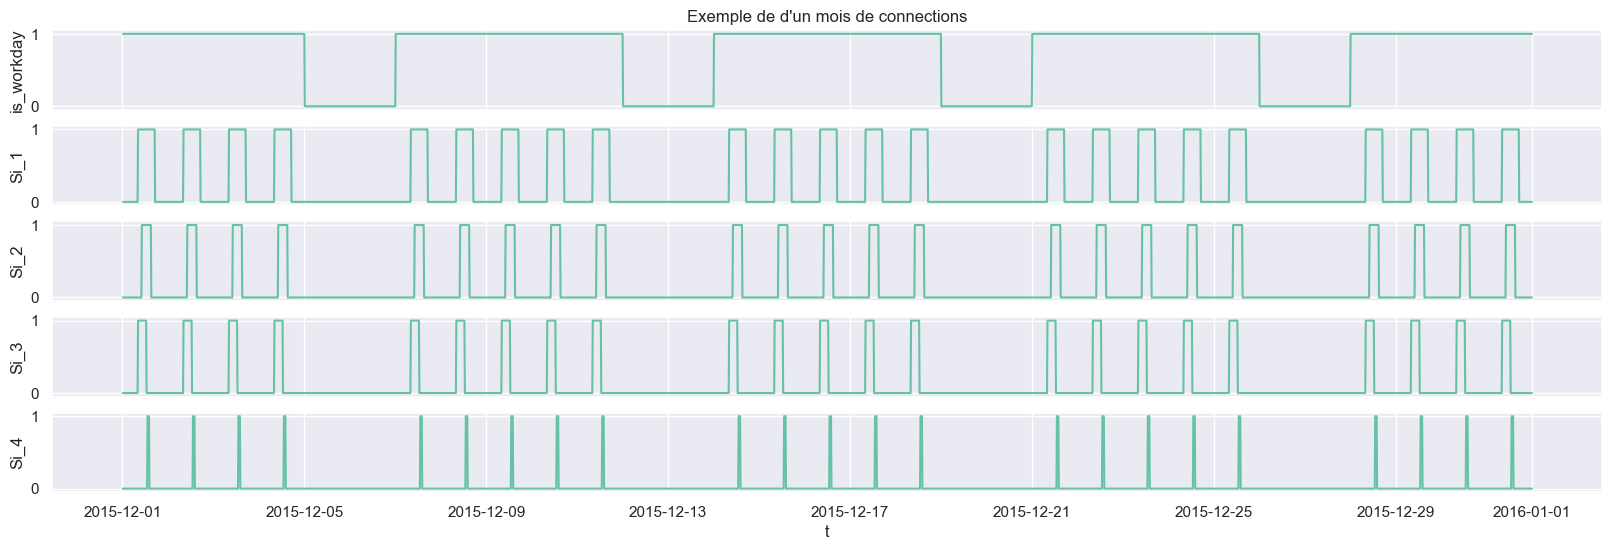

In [293]:
en = df[(df['month'] == 12) & (df['year'] == 2015)]

sig = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
#                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')
                 stop=['17:00', '15:00', '12:30', '14:00'],name='Si_')

en = pd.concat([en, sig], axis=1)

title = "Exemple de d'un mois de connections"
what= 't'

sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=5, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y='is_workday', estimator='max', data=en,  ax=axs[0])
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[1])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[4])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


In [294]:
#an = df[df['year'] == year[0]]
Si_gen = generate_Si(df,
                 start=['08:00', '10:00', '08:00', '13:00'],
                 stop=['17:00', '15:00', '12:30', '20:00'],name='Si_')#.to_numpy(copy=True)
an = pd.concat([df, Si_gen], axis=1)
#an = an[(an['week'] == 3) & (an['year'] == 2015)]

Pb = an['Power Clipped [kW]'].loc['2015-01-12':'2015-01-14']
idx = Pb.index
Pb = Pb.to_numpy(copy=True)
Si = Si_gen.loc['2015-01-12':'2015-01-14']
Si = Si.astype(float).to_numpy(copy=True)

print(Pb.shape, Si.shape)

#Pb = Pb[0:40]# 40
#idx = an.index[0:40]

l = Pb.shape[0]
print("maximum de Pb(t) clipped :{m} avec T={t}".format(m=max(Pb), t=l))
#Si = 10 * np.random.random_sample((l, 4)) - 5
#Si = np.random.randint(0, 2, size=(l, 1))
#Si = np.ones((l, 4))
#print(np.amax(Si,axis=0))
#print(Si_gen.max(axis=0))

arrivee = []
depart = []

for sign in Si.T:
    #peaks = peakdetect(si, lookahead=1, delta=0)
    # Lookahead is the distance to look ahead from a peak to determine if it is the actual peak.
    # Change lookahead as necessary
    # JUMP
    thres = 0.5
    si = sign
    y = np.where(np.logical_and(si>-thres,si<thres), 0, 1) # ACTIVITY

    der_y = np.diff(y)
    higherPeaks = np.where(der_y>=1)[0] #edge_rising = [6,13,23,27,32,41,46]
    lowerPeaks = np.where(der_y<=-1)[0] #edge_falling = [4,10, 11,16,24,29,40,43,47]
    arrivee.append(higherPeaks)
    depart.append(lowerPeaks)
    # plt.figure()
    # plt.plot(si)
    # plt.plot(higherPeaks, si[higherPeaks], 'ro')
    # plt.plot(lowerPeaks, si[lowerPeaks], 'ko')

(288,) (288, 4)
maximum de Pb(t) clipped :1334.0 avec T=288


In [295]:
print('Set problem parameters')
n_ev = 2.0
# Prius 4.4kWh, Leaf 24kWh
soc_max = 0.8*24*n_ev
soc_min = 0.2*4.4*n_ev
print("{mi} <= SOC <= {ma}".format(mi=soc_min, ma=soc_max))

bn = 1*n_ev
#bn = 40
params = {
    # Variables	Descriptions	Unités
    'Ce': 0.06319, # $/kWh (tarif D)
    # Cout depassement: kWh/j

    'SOCmin': soc_min,  # État de charge minimum des véhicules électriques	kWh
    'SOCmax': soc_max,  # État de charge maximum des véhicules électriques	kWh
    'Pch_min': 1*(4.4*(15/60))*bn,  # Puissance de charge minimum 	kW
    'Pdis_min': 1*(4.4*(15/60))*bn,  # Puissance de décharge minimum	kW
    'Pch_max_n': [bn*7.5, bn*50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    'Pdis_max_n': [bn*5.0, bn*40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW
    #'Pch_max_n': [50.0],  # Puissance de charge maximum en utilisant les bornes de type n	kW
    #'Pdis_max_n': [40.0],  # Puissance de décharge maximum en utilisant les bornes de type n	kW

    'beta_ch': 0.93,  # Efficacité de charge	%
    'beta_dis': 0.90,  # Efficacité de décharge	%
    'NEVs': n_ev,  # Nombre de véhicules électriques	Qté
    'Rut': [0.42, 0.38, 0.19, 0.11],  # Ratio d’utilisateurs avec le profil i	%
    #'Rut': [1.0],  # Ratio d’utilisateurs avec le profil i	%

    'delta_t': 15 / 60,  # 15mins
    'MAX_OPTIM': 1e8,  # Facteur majorant du programme d'optimisation

    'Pb': Pb,  # Puissance appelée par le bâtiment appelée à l’instant t	kW

    'Si': Si,#1, Si le profil d’utilisateur est raccordé à une borne à l’instant t

    'arrivee':arrivee,
    'depart':depart

}

Set problem parameters
1.7600000000000002 <= SOC <= 38.400000000000006


In [296]:
#%aimport model
#more: https://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.solution.html#docplex.mp.solution.SolveSolution
mdl = model.ModelShaving('V2B', params=params)
mdl.problem_variables()
mdl.problem_constraints()
mdl.minimize(mdl.problem_cout_depassement())
mdl.add_kpi(mdl.min(mdl.problem_cout_depassement()), "Min Cout dépassement")

#mdl.problem_constraint_unit_commitment()

print('\n')
mdl.print_information()
solus = mdl.solve()
assert solus, "!!! Solve of the model fails"
print("********************************************")
print("Obj", mdl.solution.get_objective_value())
#mdl.print_solution(print_zeros=False)
print("--------------------------------------------")
mdl.report()
print("--------------------------------------------")
print('end')
with open('solution.pickle', mode='wb') as f:
    pickle.dump(solus, f)
filename = Path(save_dir,'solution.json')
with open('solution.pickle', mode='wb') as f:
    solus.export(f,format='json')

[[0.75 0.5  0.5  0.5 ]
 [0.25 0.5  0.5  0.5 ]]


Model: V2B
 - number of variables: 22752
   - binary=6912, integer=0, continuous=15840
 - number of constraints: 22780
   - linear=22780
 - parameters: defaults
 - objective: minimize
 - problem type is: MILP
********************************************
Obj 2444.1999999999903
--------------------------------------------
* model V2B solved with objective = 2444.200
*  KPI: Min Cout dépassement = 2444.200
--------------------------------------------
end


n  i
1  1    1326.2
   2    1326.2
   3    1326.2
   4    1326.2
2  1    1256.2
   2    1256.2
   3    1256.2
   4    1256.2
dtype: float64


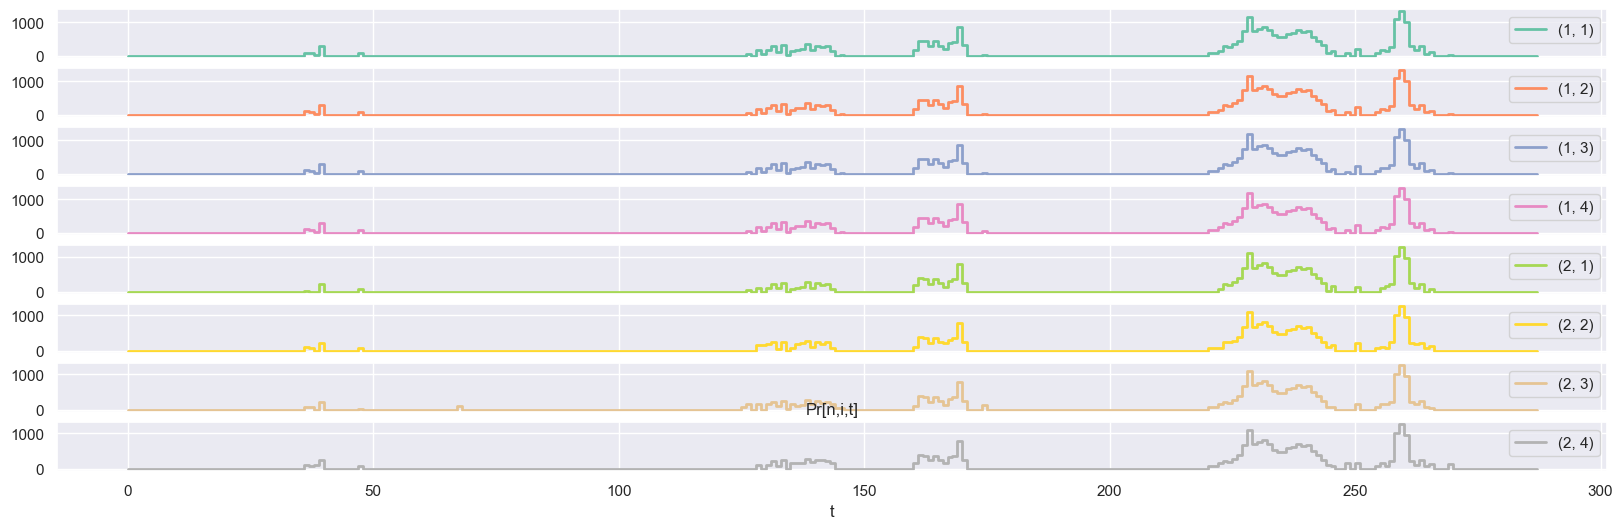

In [297]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pr__n_i_t, index='t', columns=['n', 'i'])
#df_con__n_i_t.plot(figsize=figure_size,subplots=True, linestyle='none', marker='.')
df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
plt.title('Pr[n,i,t]')
print(df_var.max())

n  i
1  1    10.0
   2    10.0
   3    10.0
   4    10.0
2  1    80.0
   2    80.0
   3    80.0
   4    80.0
dtype: float64


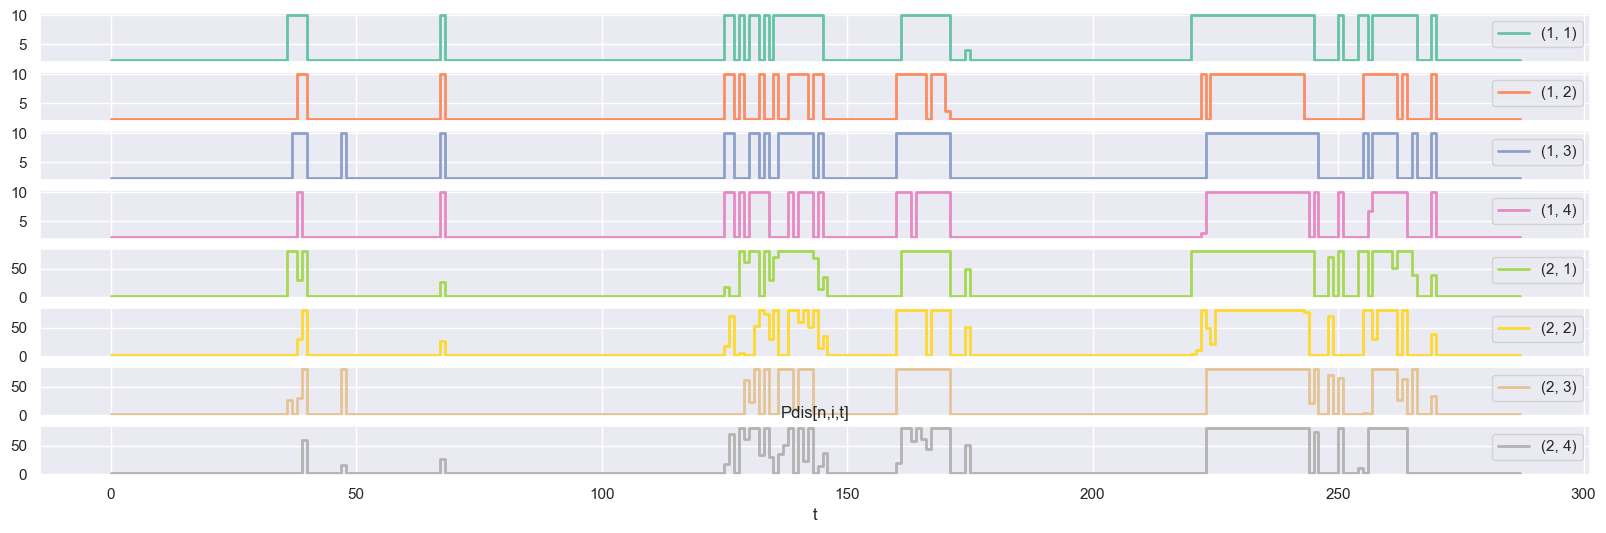

In [298]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pdis__n_i_t, index='t', columns=['n', 'i'])
#df_con__n_i_t.plot(figsize=figure_size,subplots=True, linestyle='none', marker='.')
df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
plt.title('Pdis[n,i,t]')
print(df_var.max())

n  i
1  1     15.0
   2     15.0
   3     15.0
   4     15.0
2  1      3.6
   2    100.0
   3    100.0
   4    100.0
dtype: float64


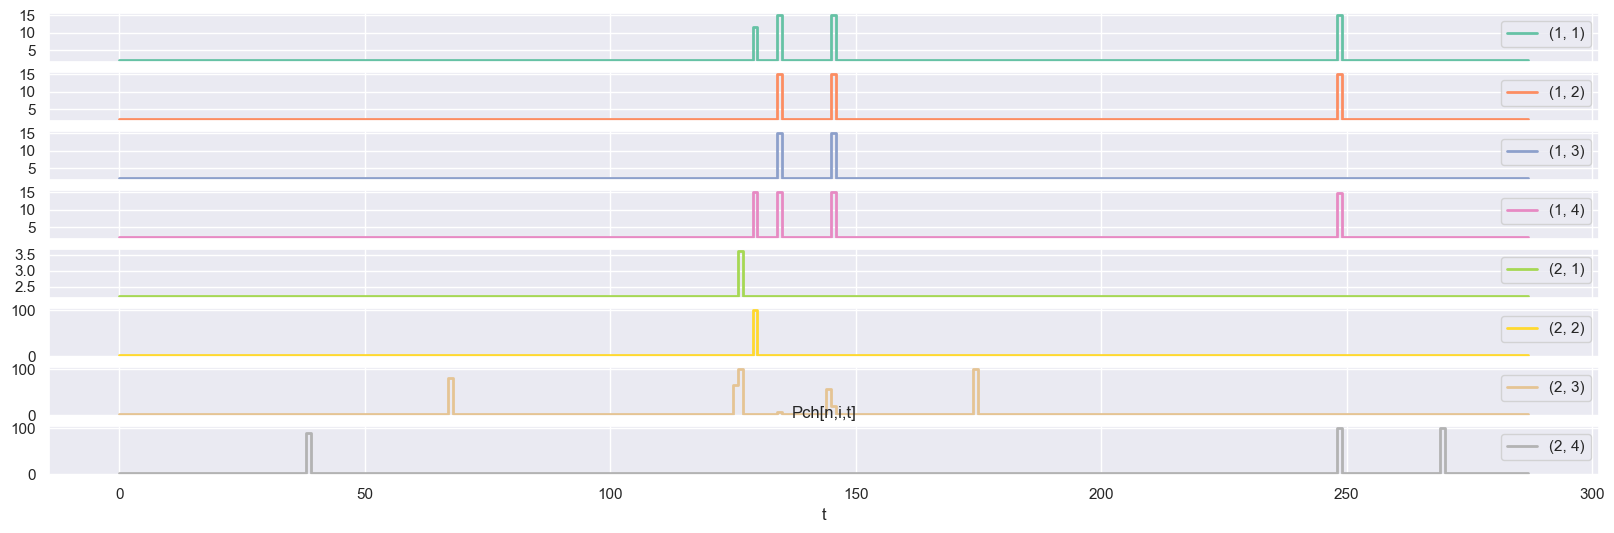

In [299]:
df_var = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch__n_i_t, index='t', columns=['n', 'i'])
#df_con__n_i_t.plot(figsize=figure_size,subplots=True, linestyle='none', marker='.')
df_var.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
plt.title('Pch[n,i,t]')
print(df_var.max())

Text(0.5, 1.0, 'Connection moments (con__n_i_t)')

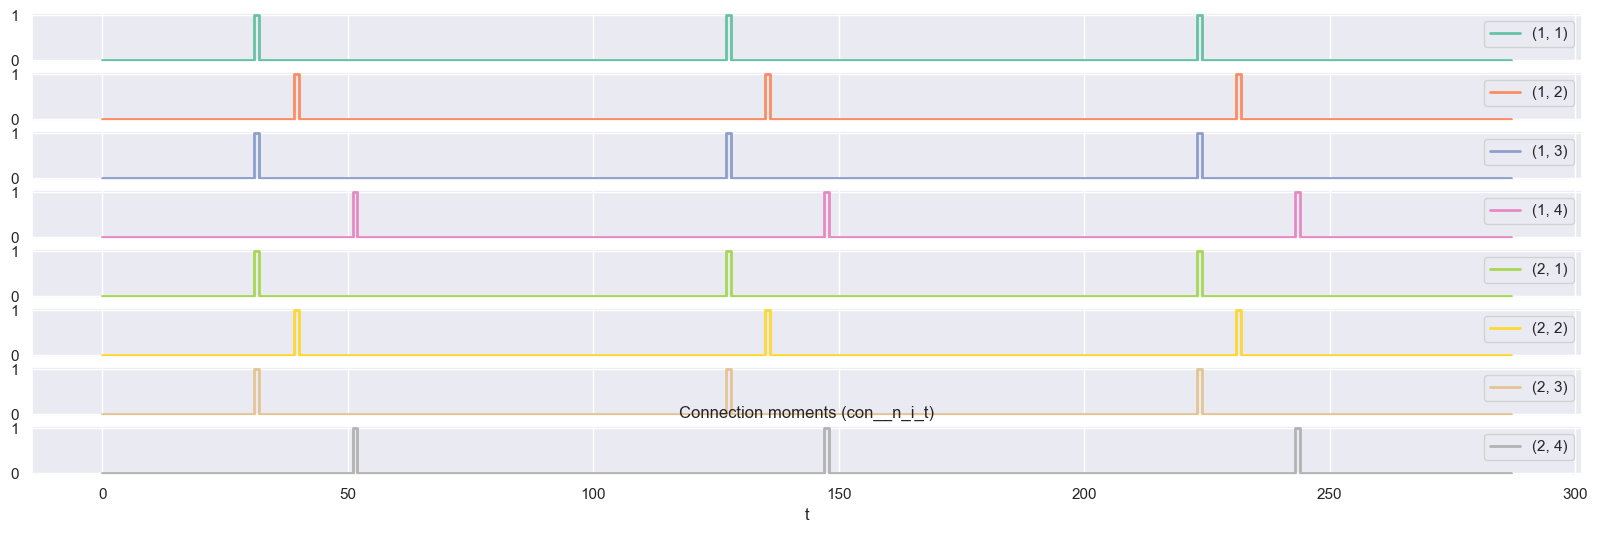

In [300]:
df_con__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.con__n_i_t, index='t', columns=['n', 'i'])
#df_con__n_i_t.plot(figsize=figure_size,subplots=True, linestyle='none', marker='.')
df_con__n_i_t.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
plt.title('Connection moments (con__n_i_t)')

Text(0.5, 1.0, 'Diconnection moments (dicon__n_i_t)')

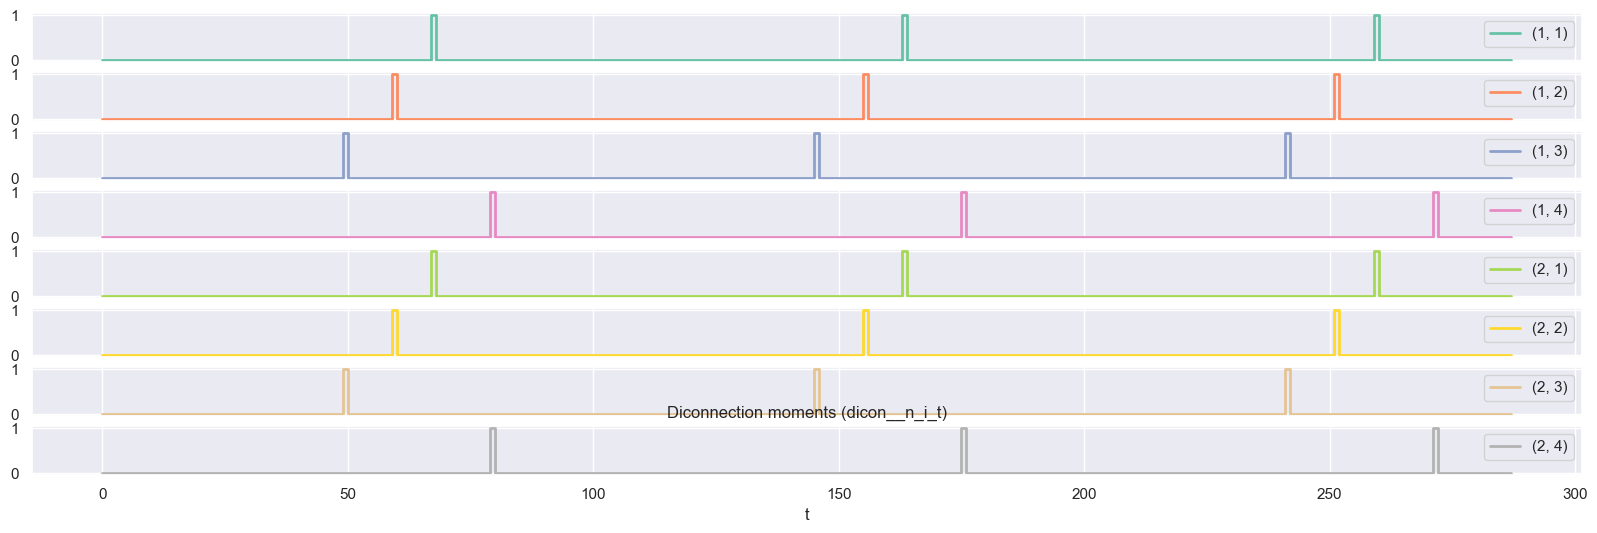

In [301]:
df_discon__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.discon__n_i_t, index='t', columns=['n', 'i'])
#df_con__n_i_t.plot(figsize=figure_size,subplots=True, linestyle='none', marker='.')
df_discon__n_i_t.plot(figsize=figure_size,subplots=True, drawstyle="steps", linewidth=2)
plt.title('Diconnection moments (dicon__n_i_t)')

In [326]:
dk = pd.DataFrame({'Pb batiment': mdl.params['Pb'],
                   'Pr reseau': solus.get_value_list(mdl.Pr__t),
                   'P charge totale': solus.get_value_list(mdl.Pch_tot__t),
                   'P décharge totale': solus.get_value_list(mdl.Pdis_tot__t),
                   #'t':idx
                   }
                  ).set_index(idx)

In [303]:
df_Pch__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pch__i_t__')
#print(df_Pch__i_t)
df_Pdis__i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Pch_demand_i_t,
                                 index='t', columns='i', prefix='Pdis__i_t__')
#print(df_Pdis__i_t)
df_SOC__n_i_t = mdl.var_dict_as_df(solution=solus, var_dict=mdl.SOC__n_i_t, index='t', columns=['n', 'i'])
#df_SOC__n_i_t.rename(mapper=lambda x: f'N_{x}', axis='columns', level=0, inplace=True)
#df_SOC__n_i_t.rename(mapper=lambda x: f'I_{x}', axis='columns', level=1, inplace=True)
#print(df_SOC__n_i_t)

In [304]:
#df_Rborne__n_i = mdl.var_dict_as_df(solution=solus, var_dict=mdl.Rborne__n_i,
#                                 index='i', columns='n')
#print(df_Rborne__n_i)

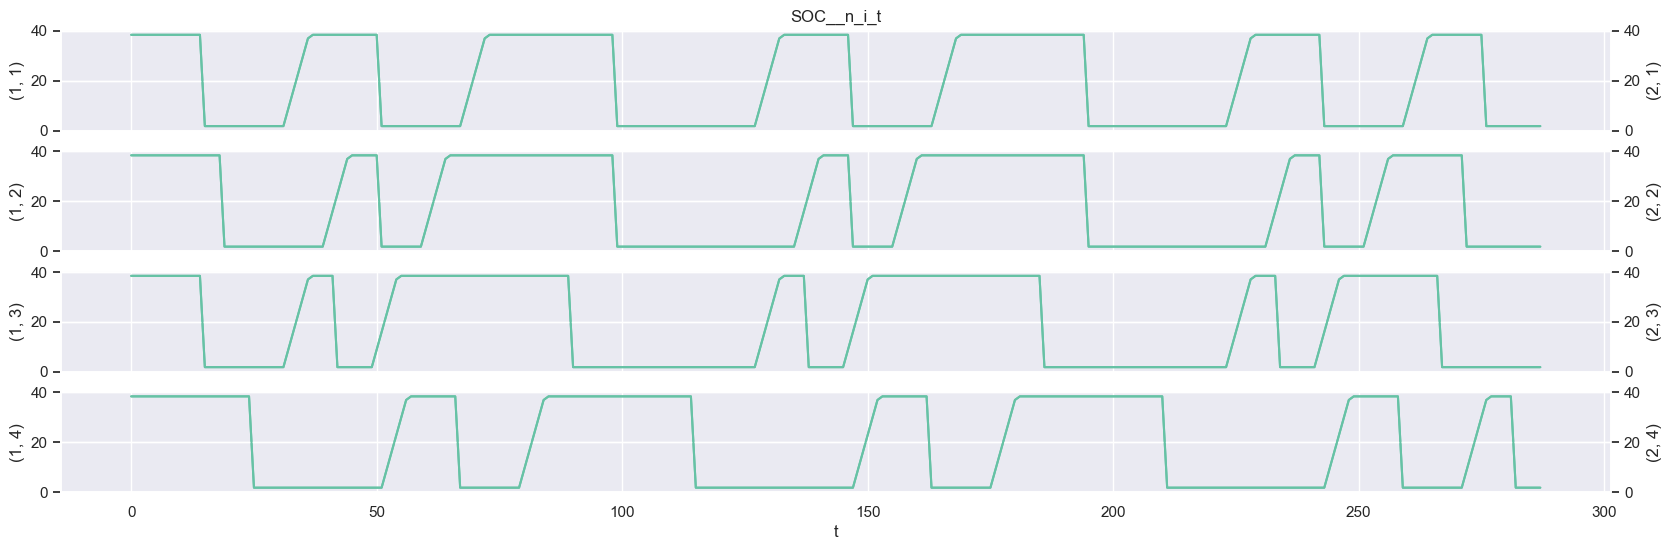

In [312]:
# Error Bands + valeur maximale des mois

title = "SOC__n_i_t"

what= 't'

#sns.set_theme(style="ticks")
sns.set_theme(style="darkgrid",palette='Set2')

fig, axs = plt.subplots(nrows=4, figsize=figure_size, sharex=True)
g = sns.lineplot(x=what, y=(1,1), estimator='max', data=df_SOC__n_i_t,  ax=axs[0])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,1), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,2), estimator='max', data=df_SOC__n_i_t, ax=axs[1])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,2), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,3), estimator='max', data=df_SOC__n_i_t, ax=axs[2])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,3), estimator='max', data=df_SOC__n_i_t, ax=ax2)
g = sns.lineplot(x=what, y=(1,4), estimator='max', data=df_SOC__n_i_t, ax=axs[3])
ax2 = g.twinx()
h = sns.lineplot(x=what, y=(2,4), estimator='max', data=df_SOC__n_i_t, ax=ax2)


for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


/var/folders/ml/k9khjmr57qqcw3y03b7k154c0000gn/T/ipykernel_9141/2995283003.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dk.plot(figsize=figure_size,subplots=True, ax=ax)


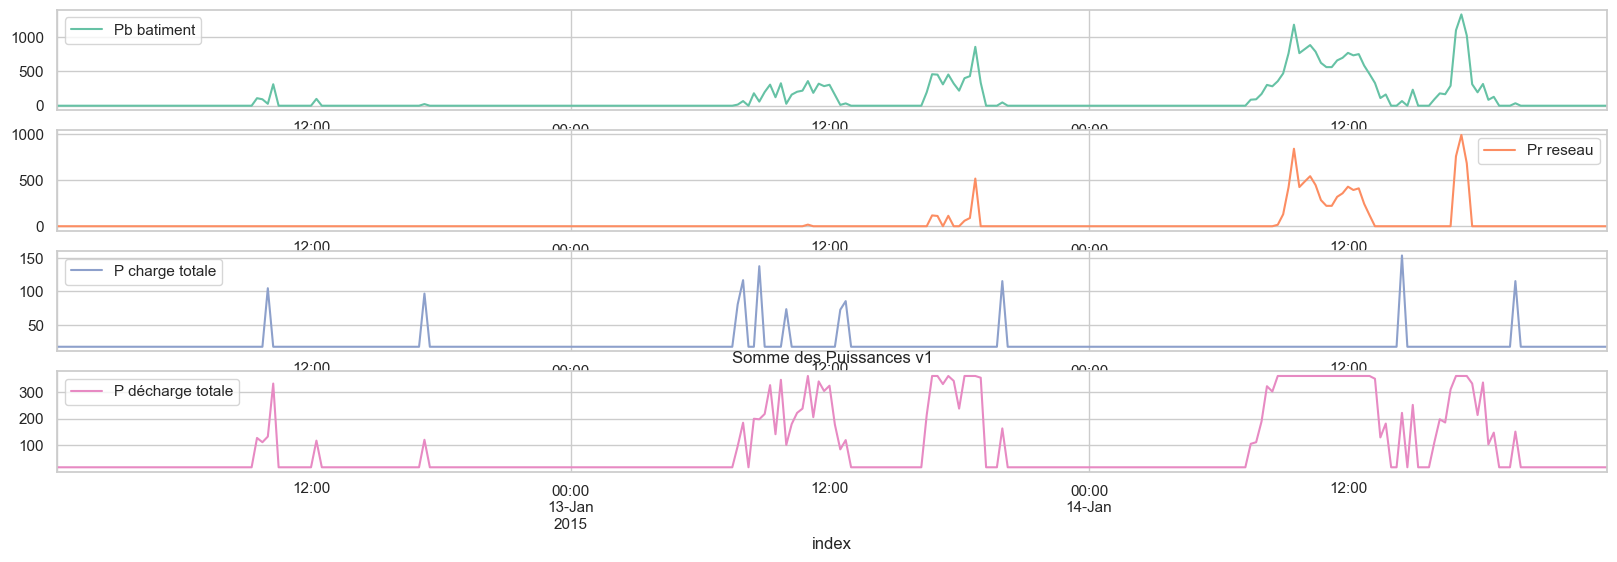

In [332]:
title = "Somme des Puissances v1"
sns.set_style("whitegrid")
#fig=plt.figure()
fig, ax = plt.subplots(figsize=figure_size, sharex=True)
dk.plot(figsize=figure_size,subplots=True, ax=ax)
#for char in invalid:
#	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,title+'.png')
plt.title(title)
plt.show()
fig = ax.get_figure()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


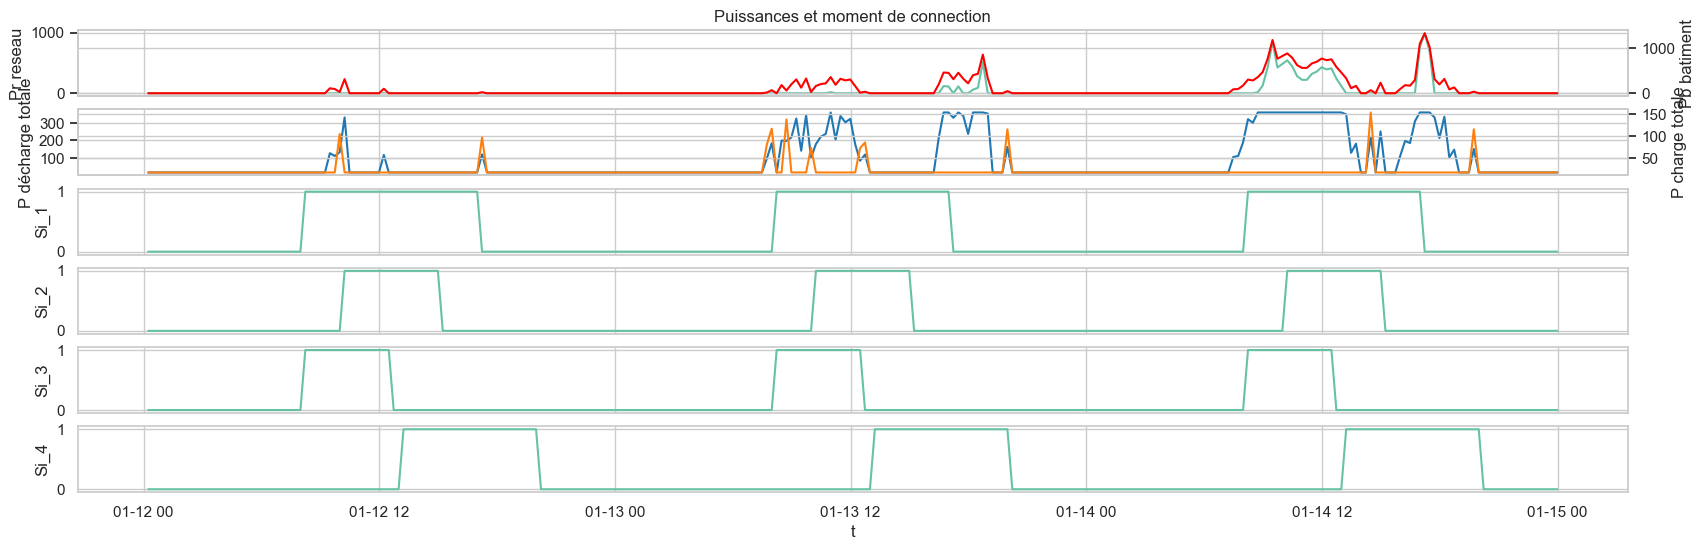

In [311]:
title = 'Puissances et moment de connection'
en = pd.DataFrame(mdl.params['Si'], columns=['Si_1', 'Si_2','Si_3','Si_4'])
en['t'] = idx
sns.set_style("whitegrid")
fig, axs = plt.subplots(nrows=6, figsize=figure_size, sharex=True)
g = sns.lineplot(x=dk.index, y='Pr reseau', estimator='max', data=dk,  ax=axs[0])
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='Pb batiment', estimator='max', data=dk, ax=ax2, color='r',dashes=True)
g = sns.lineplot(x=dk.index, y='P décharge totale', estimator='max', data=dk,  ax=axs[1], color='tab:blue')
ax2 = g.twinx()
h = sns.lineplot(x=dk.index, y='P charge totale', estimator='max', data=dk, ax=ax2, color='tab:orange')
g = sns.lineplot(x=what, y='Si_1', estimator='max', data=en, ax=axs[2])
g = sns.lineplot(x=what, y='Si_2', estimator='max', data=en, ax=axs[3])
g = sns.lineplot(x=what, y='Si_3', estimator='max', data=en, ax=axs[4])
g = sns.lineplot(x=what, y='Si_4', estimator='max', data=en, ax=axs[5])

for char in invalid:
	filename = title.replace(char, '_')+'.png'
filename = Path(save_dir,filename)

axs[0].title.set_text(title)
plt.show()
fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')


In [308]:
import docx
from docx import Document

doc = Document()
doc.add_heading('Résumé des informations du problème', 0)

doc.add_paragraph('Rborne[n,i]')
t_df = pd.DataFrame(mdl.Rborne__n_i)

# add a table to the end and create a reference variable
# extra row is so we can add the header row
t = doc.add_table(t_df.shape[0]+1, t_df.shape[1])
#t.style = 'LightShading-Accent1'
# add the header rows.
for j in range(t_df.shape[-1]):
    t.cell(0,j).text = str(t_df.columns[j])
# add the rest of the data frame
for i in range(t_df.shape[0]):
    print(i)
    r = t_df.index[i]
    for j in range(t_df.shape[-1]):
        t.cell(i+1,j).text = str(t_df.values[i,j])

# save the doc
doc.save(Path(save_dir, 'tables.docx'))

0
1
